In [1]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [4]:
corede = geopandas.read_file("corede_rs/corede_rs_4326_20081125_1033.shp")
corede.crs = "EPSG:4326"

In [5]:
corede.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
ucs = geopandas.read_file("ucs/ucstodas.shp")
ucs.crs = "EPSG:4326"

In [7]:
ucs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
ucs_cat = np.unique(ucs['CATEGORI3'])

In [9]:
uc_mun = geopandas.read_file("uc_munip/Limites_UCs_Municipais_RS-polygon.shp")
uc_mun.crs = "EPSG:4326"

In [10]:
uc_mun_dic = {
    'APA':'Área de Proteção Ambiental',
    'ARIE':'Área de Relevante Interesse Ecológico',
    'MoNa':'Monumento Natural',
    'PNM':'Parque',
    'REBIO':'Reserva Biológica',
    'Rebio':'Reserva Biológica',
    'RVS':'Refúgio de Vida Silvestre',
}

uc_mun['tipo'] = 'N/D'
for idx, row in uc_mun.iterrows():
    cod = row['Name'].split()[0]
    for i in uc_mun_dic:
        if cod == i:
            uc_mun.loc[idx, 'tipo'] = uc_mun_dic[i]

In [11]:
ti = geopandas.read_file("ti_sirgas/ti_sirgasPolygon.shp")
ti.crs = "EPSG:4326"

In [12]:
ti.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
qui = geopandas.read_file("Áreas de Quilombolas_RS/Áreas de Quilombolas_RS.shp")
qui.crs = "EPSG:4326"

In [14]:
ass = geopandas.read_file("Assentamento Brasil_RS/Assentamento Brasil_RS.shp")
ass.crs = "EPSG:4326"

In [15]:
fl = geopandas.read_file("florestas/florestaspublicas.shp")
fl.crs = "EPSG:4326"

In [16]:
fl.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
sigmine = geopandas.read_file("RS/RS.shp")
sigmine.crs = "EPSG:4326"
sigmine['ANM'] = 'ANM'

In [18]:
np.unique(sigmine['FASE'])

array(['AUTORIZAÇÃO DE PESQUISA', 'CONCESSÃO DE LAVRA',
       'DIREITO DE REQUERER A LAVRA', 'DISPONIBILIDADE',
       'LAVRA GARIMPEIRA', 'LICENCIAMENTO', 'REGISTRO DE EXTRAÇÃO',
       'REQUERIMENTO DE LAVRA', 'REQUERIMENTO DE LAVRA GARIMPEIRA',
       'REQUERIMENTO DE LICENCIAMENTO', 'REQUERIMENTO DE PESQUISA',
       'REQUERIMENTO DE REGISTRO DE EXTRAÇÃO'], dtype=object)

In [19]:
#filtro_req1 = sigmine['FASE'] != 'REQUERIMENTO DE PESQUISA'
#filtro_req2 = sigmine['FASE'] != 'REQUERIMENTO DE LICENCIAMENTO'
#filtro_req3 = sigmine['FASE'] != 'REQUERIMENTO DE LAVRA GARIMPEIRA'
#filtro_req4 = sigmine['FASE'] != 'REQUERIMENTO DE REGISTRO DE EXTRAÇÃO'

#sigmine = sigmine[filtro_req1 & filtro_req2 & filtro_req3 & filtro_req4]

In [20]:
municipios = geopandas.read_file("municipios/Municipios_IBGE.shp")

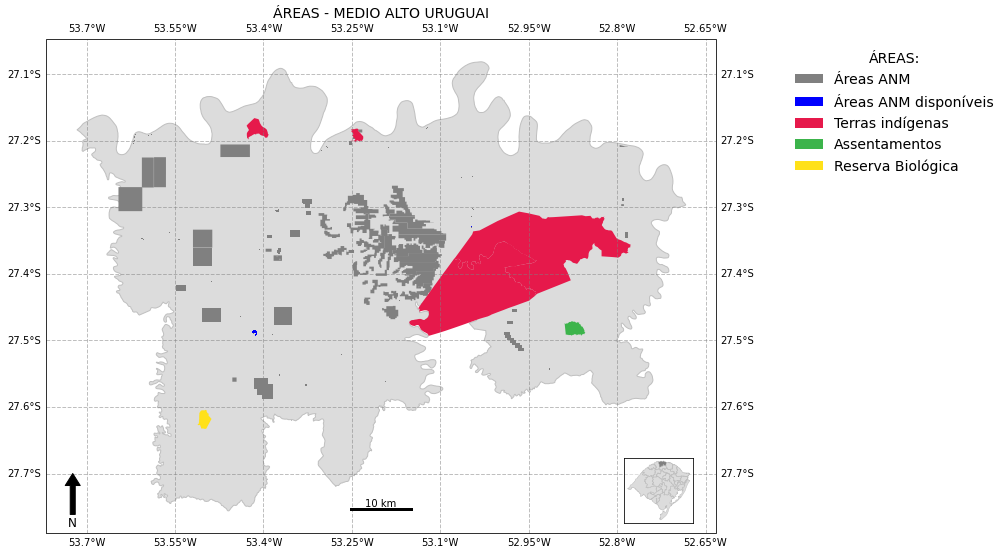

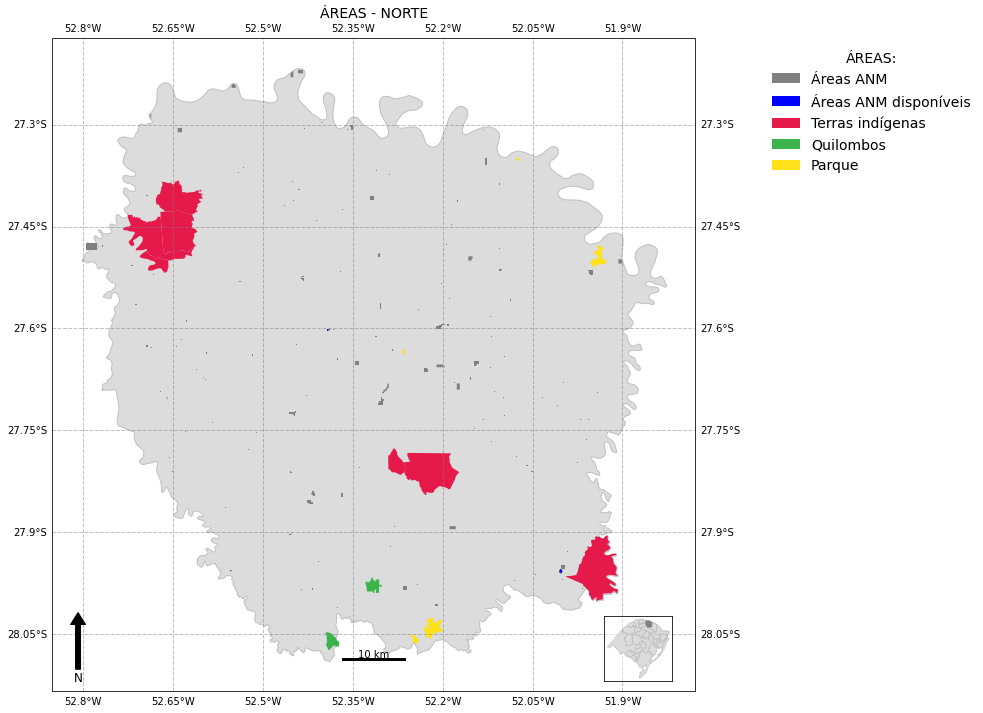

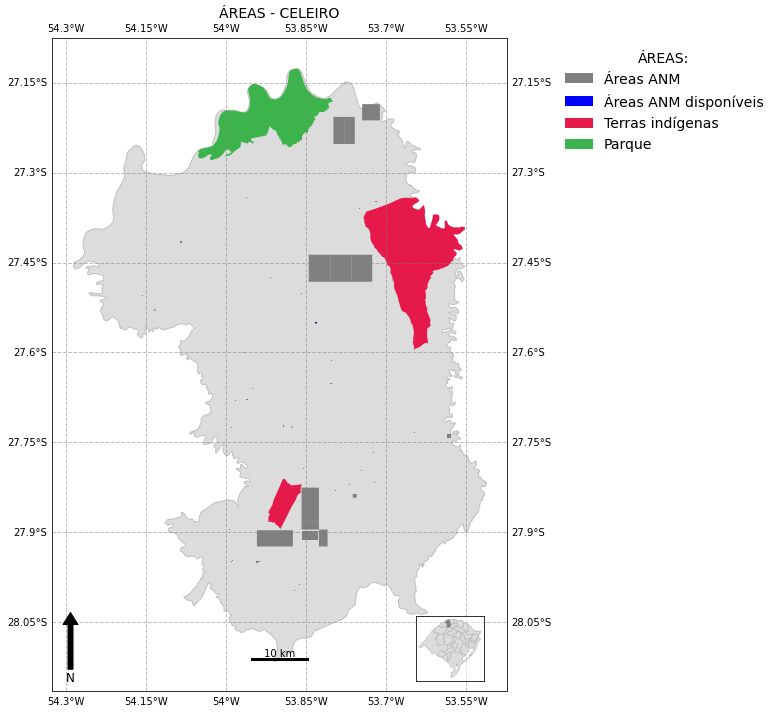

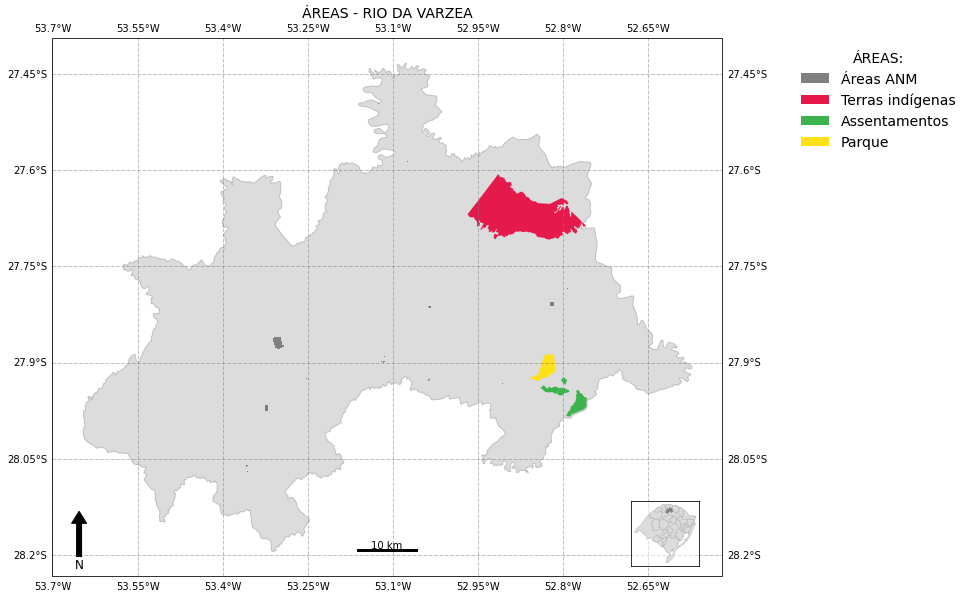

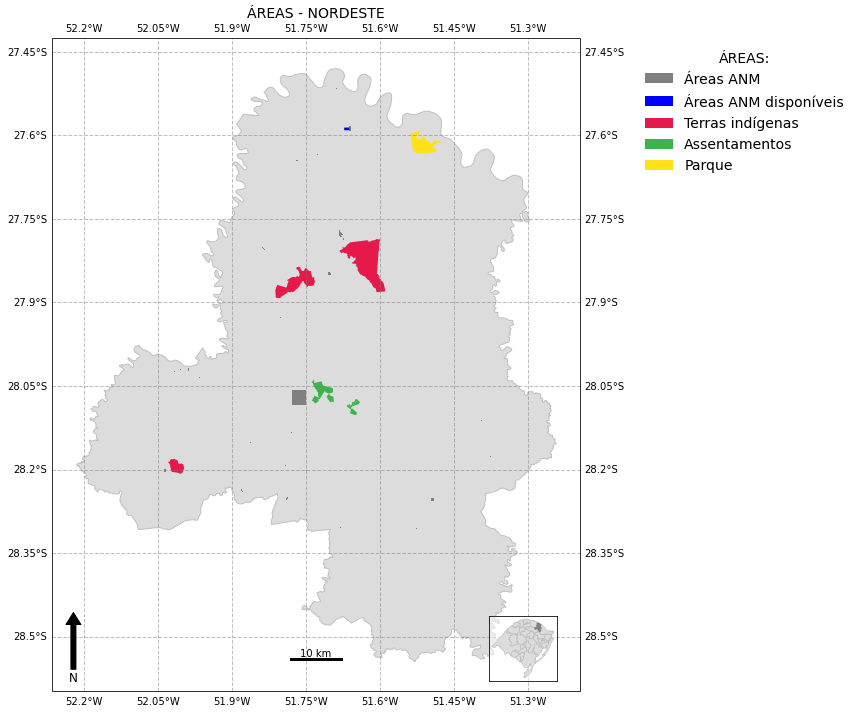

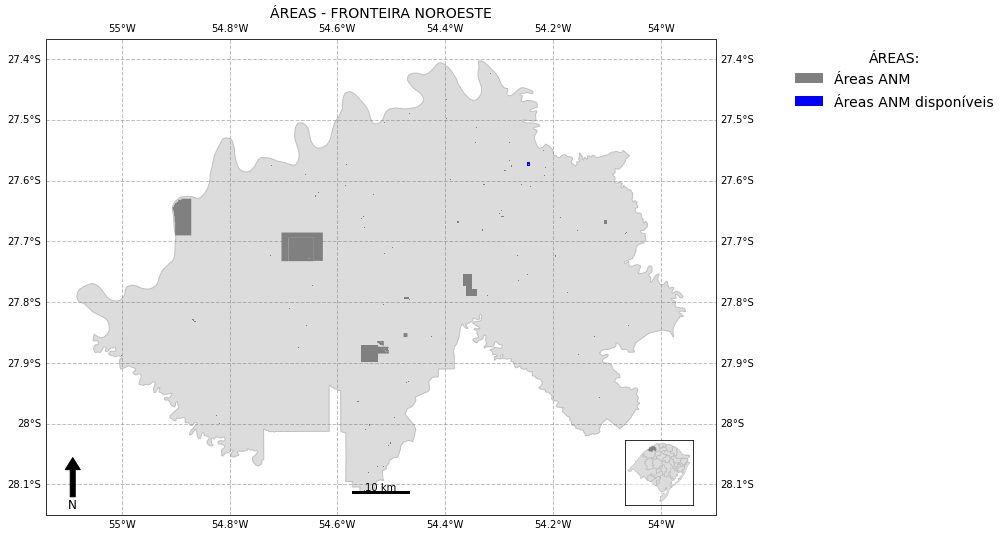

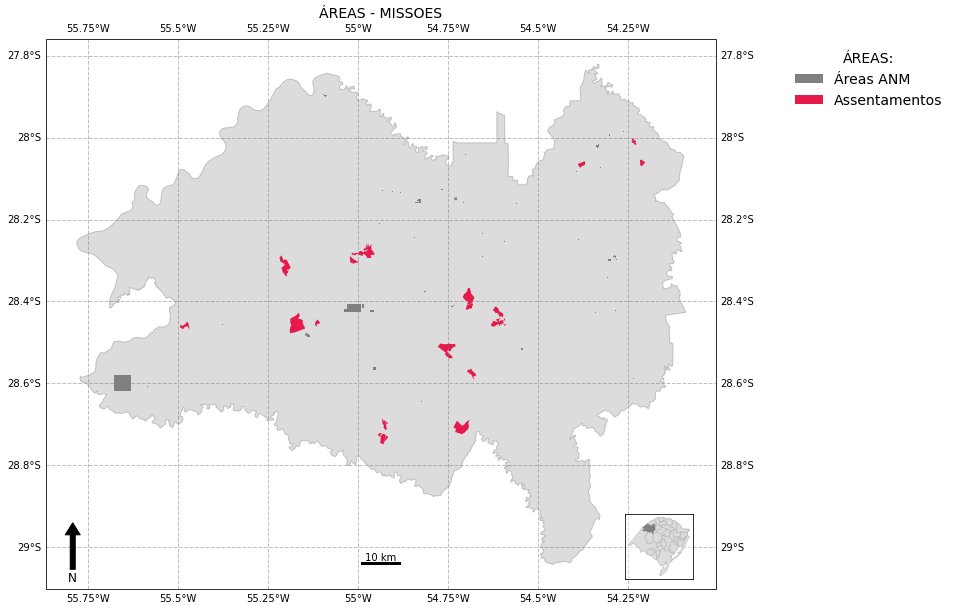

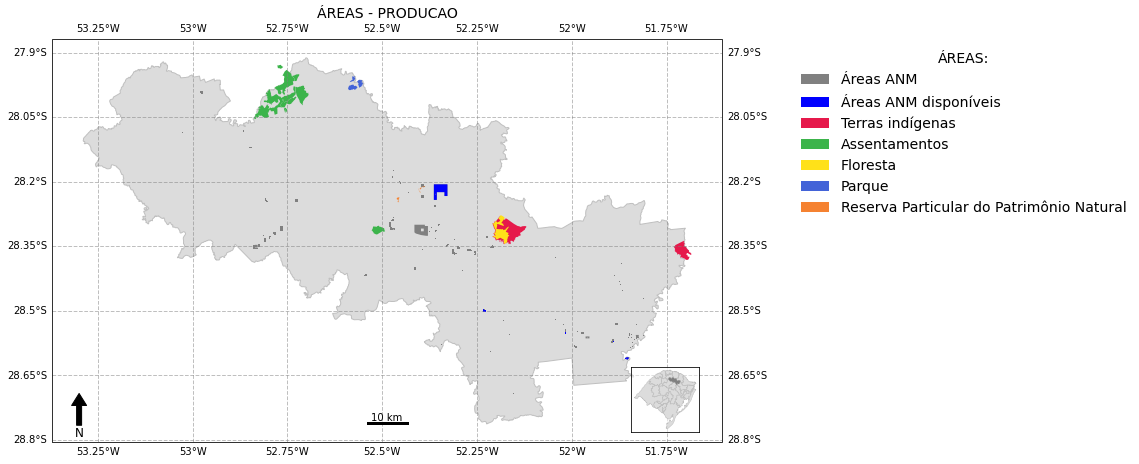

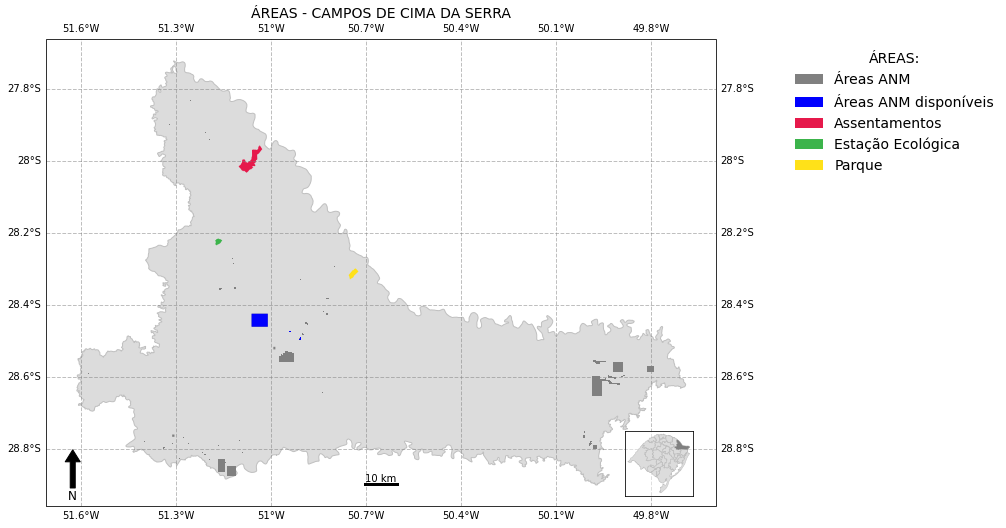

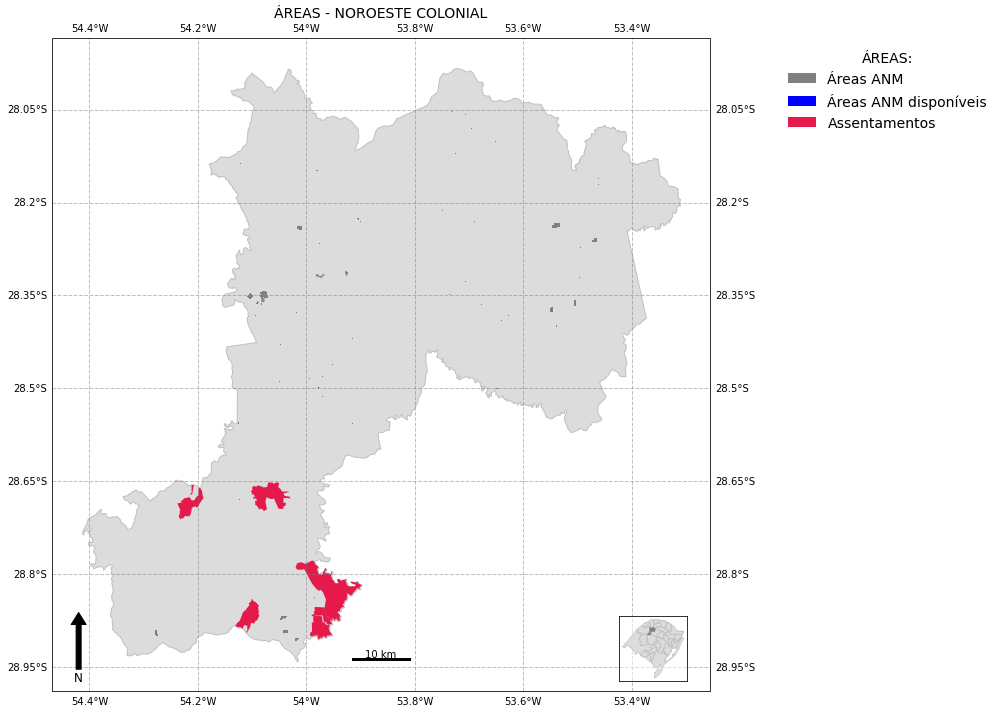

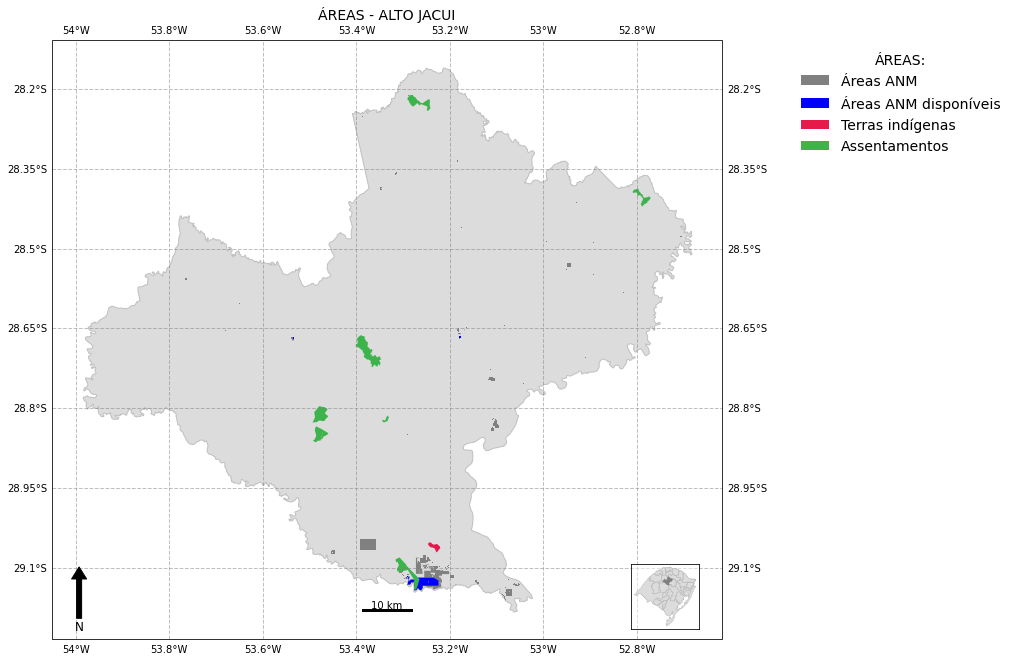

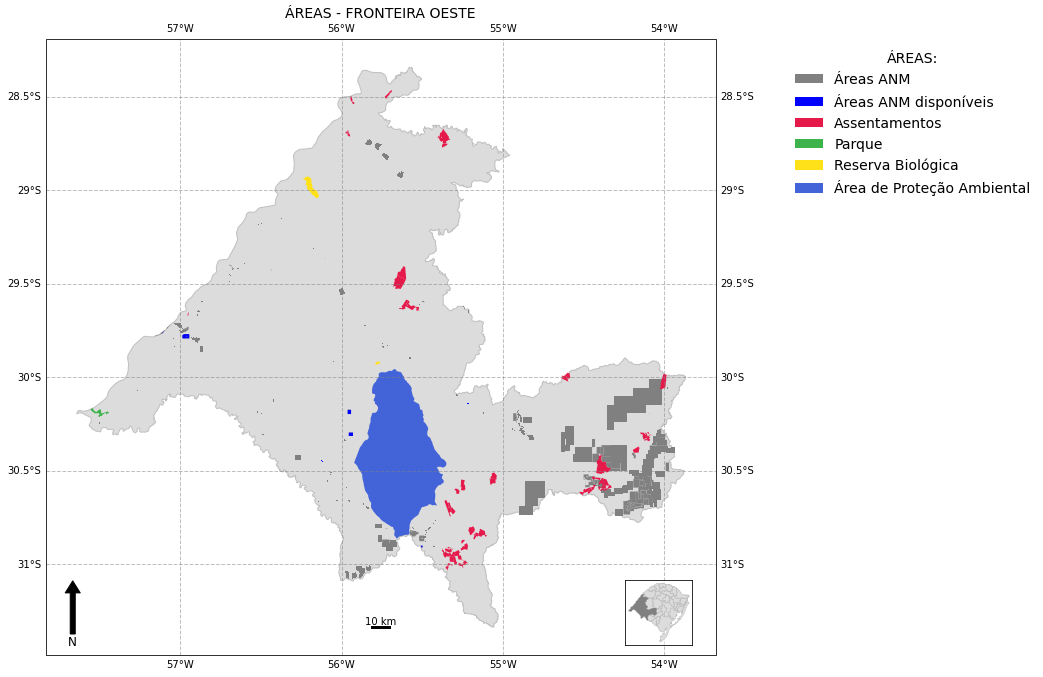

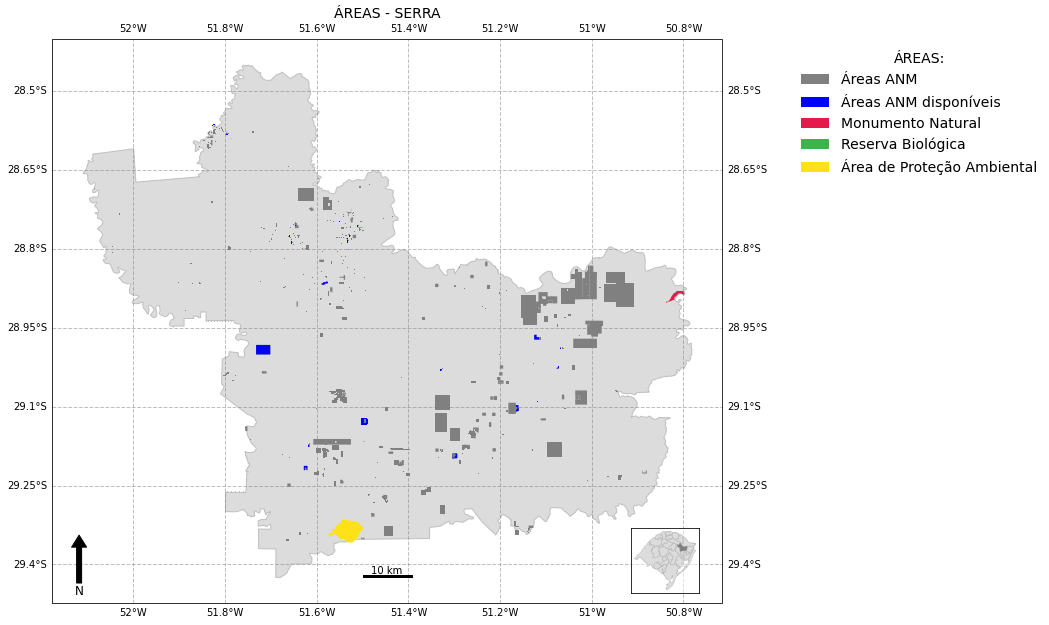

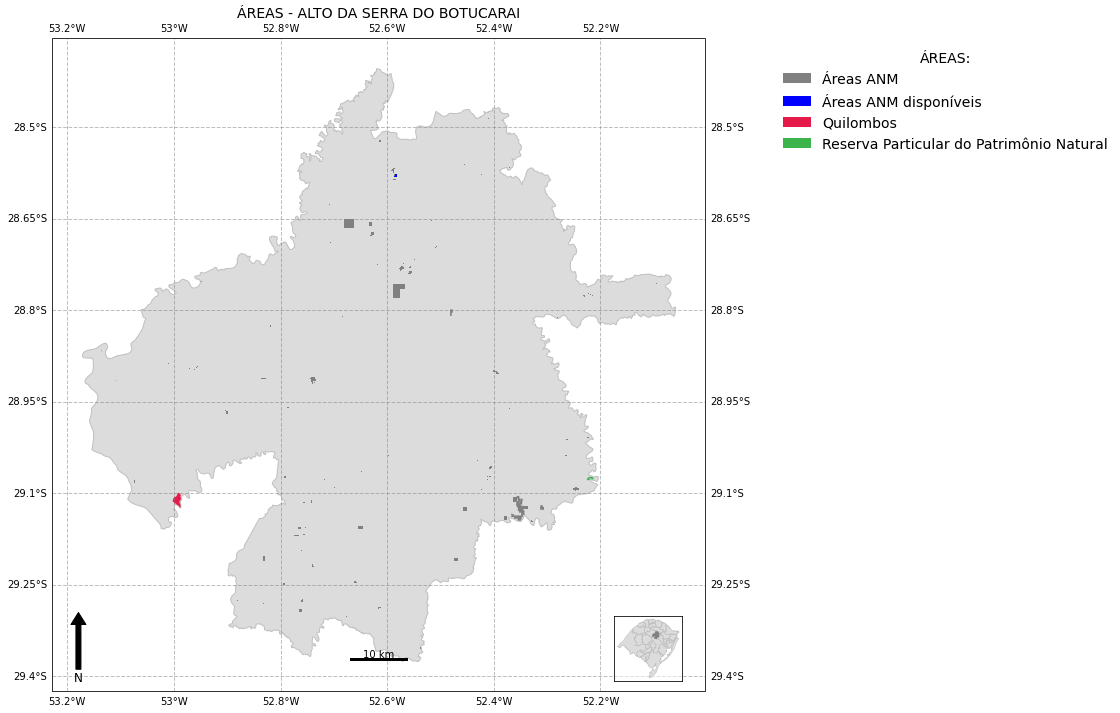

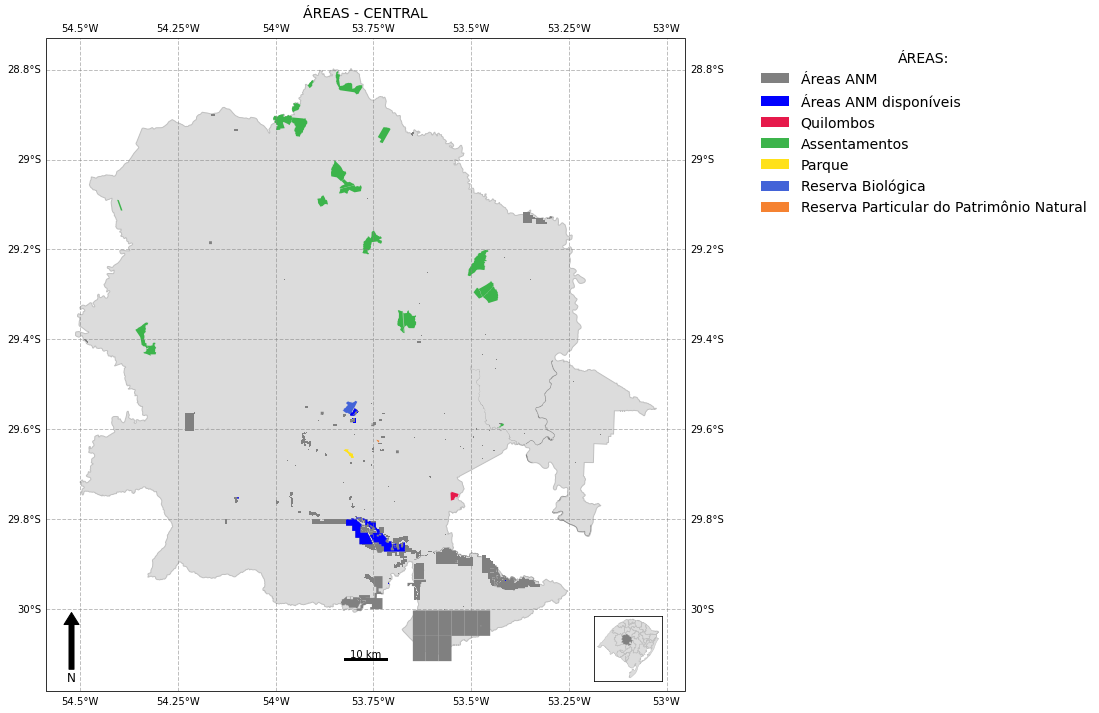

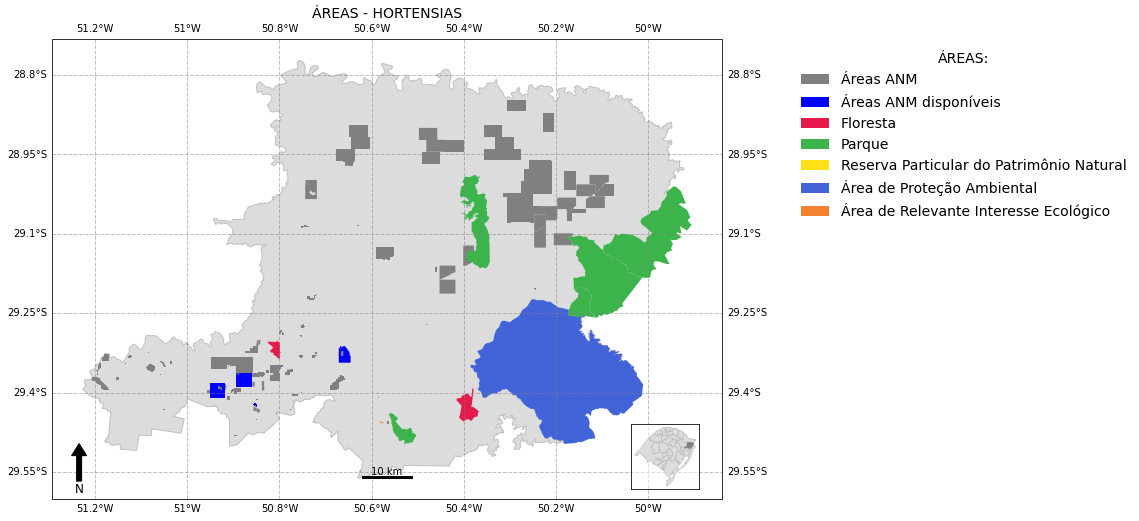

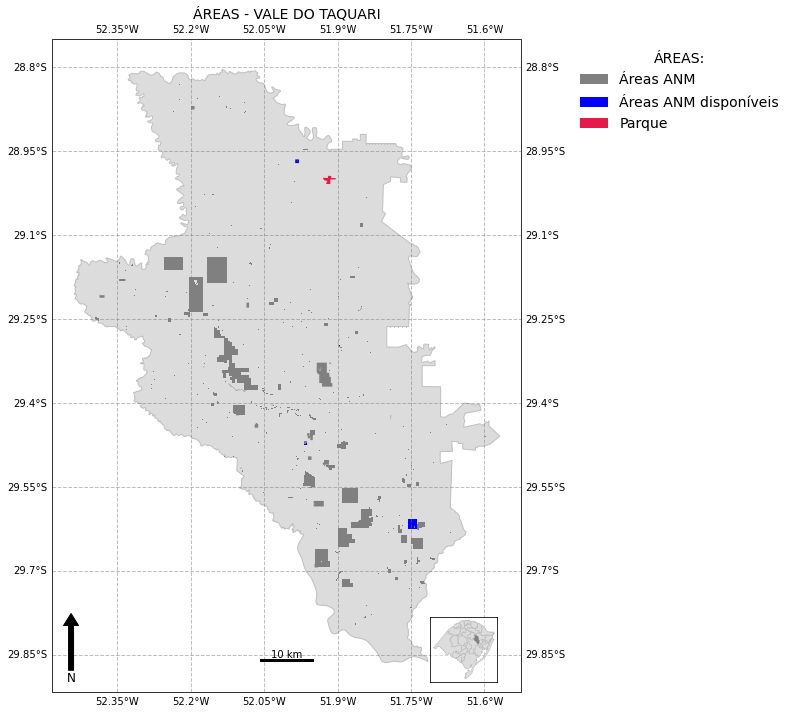

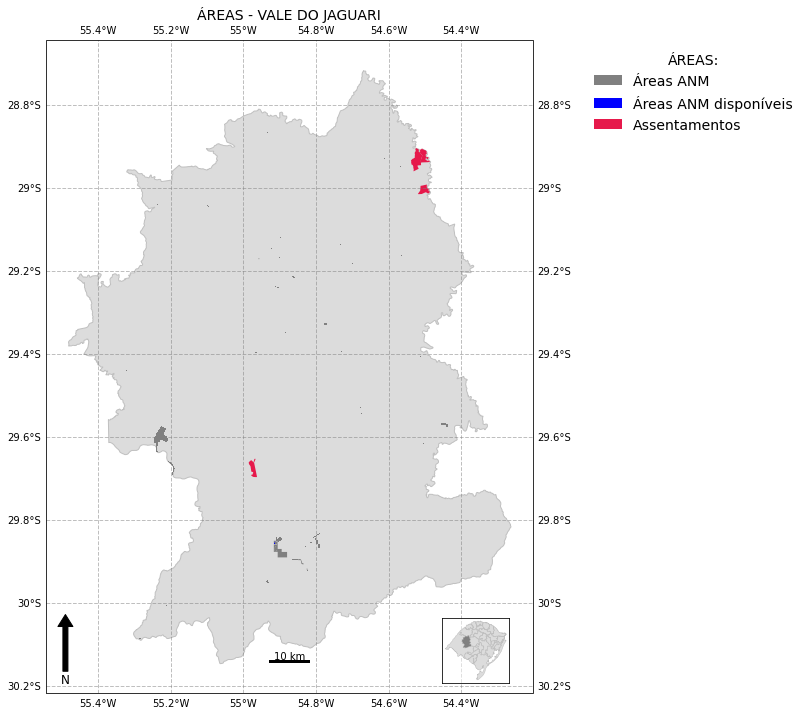

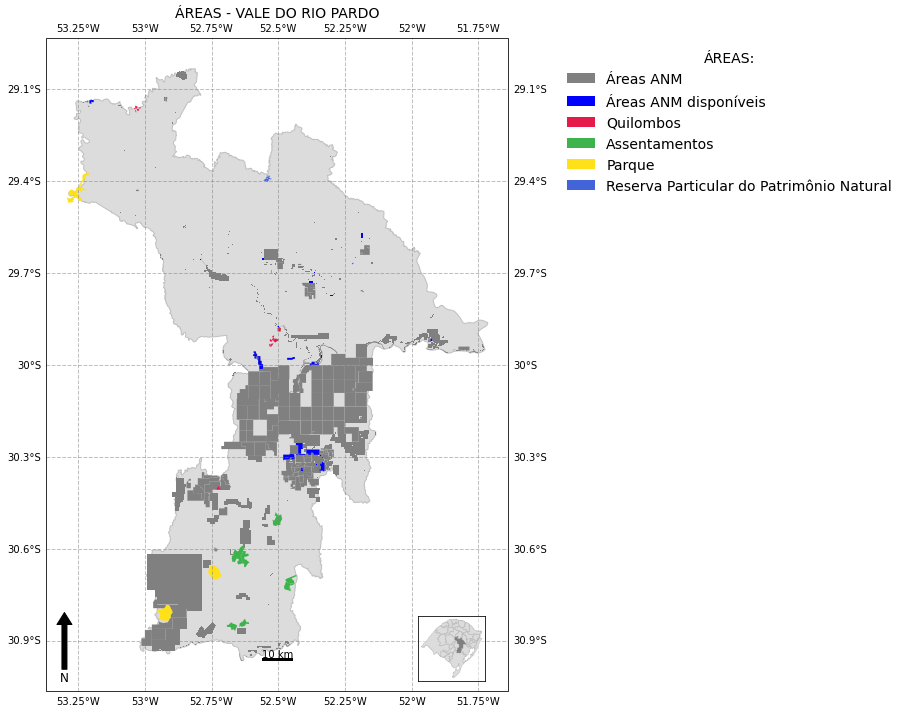

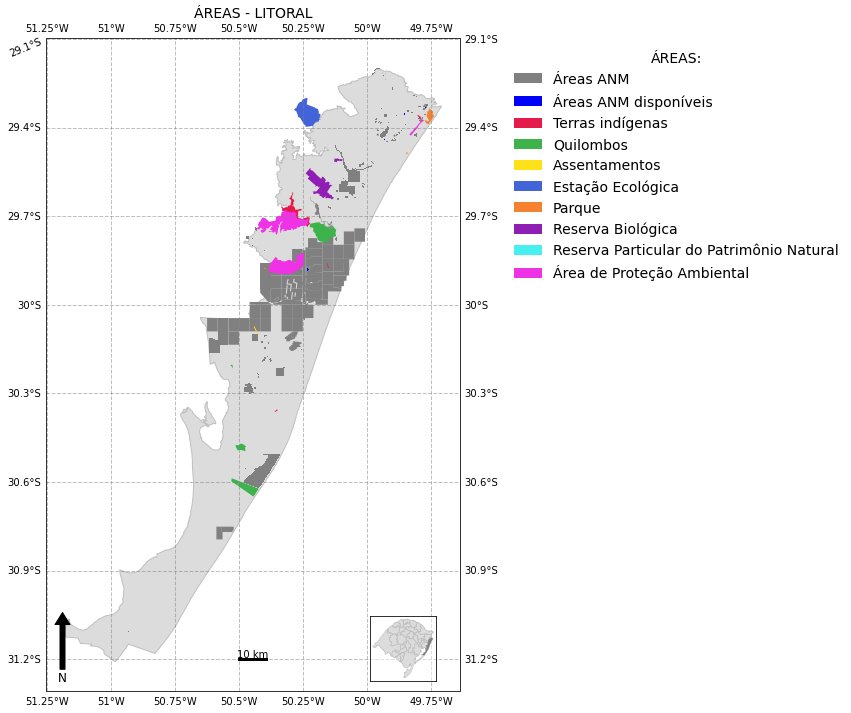

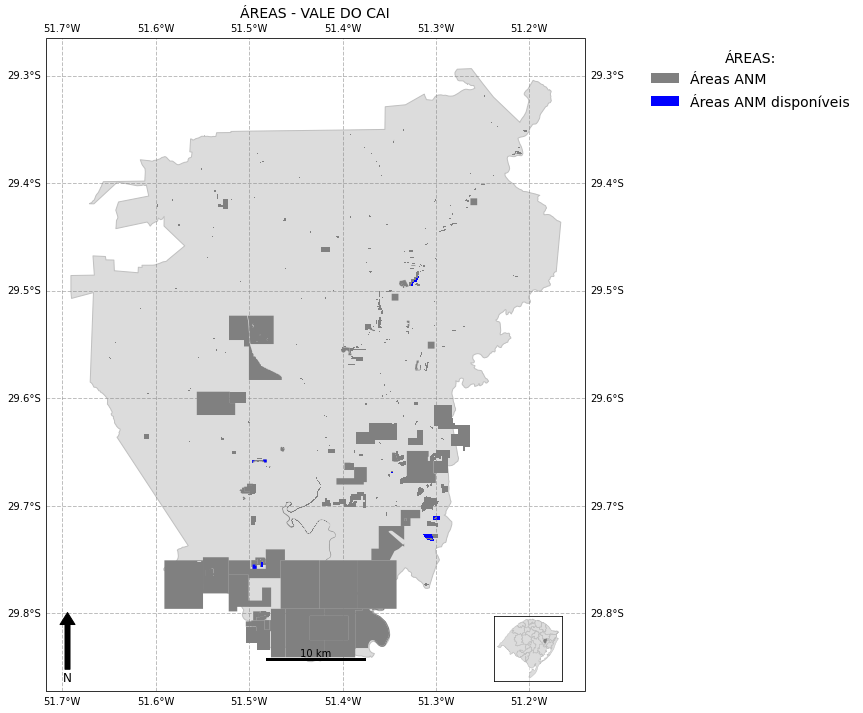

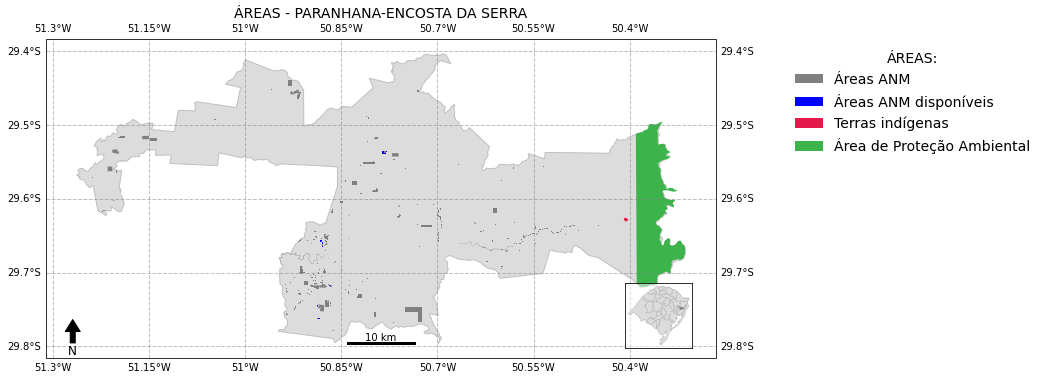

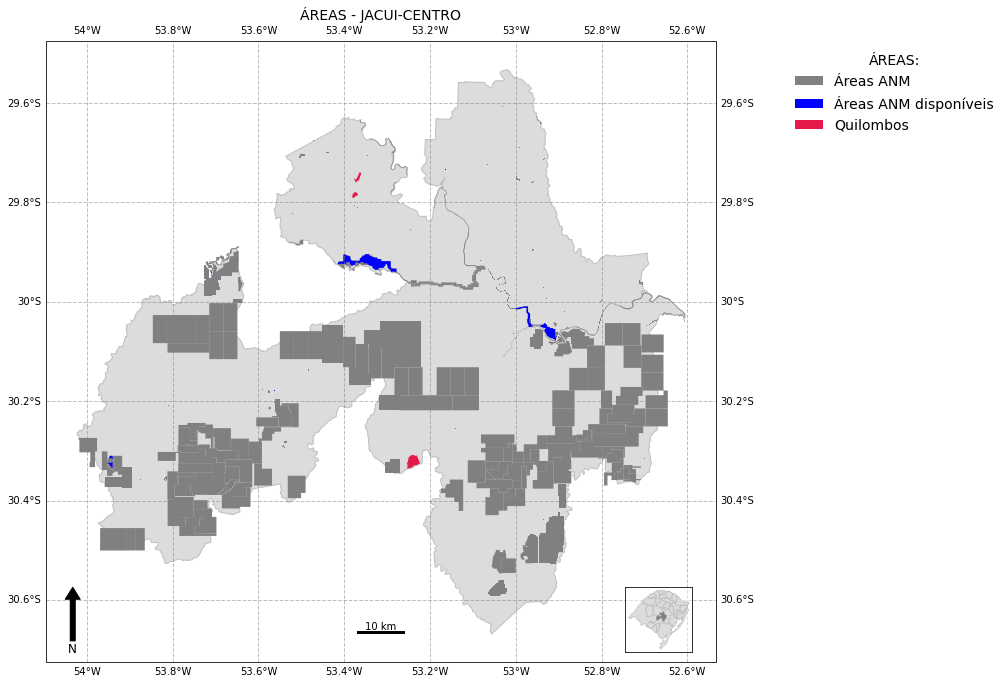

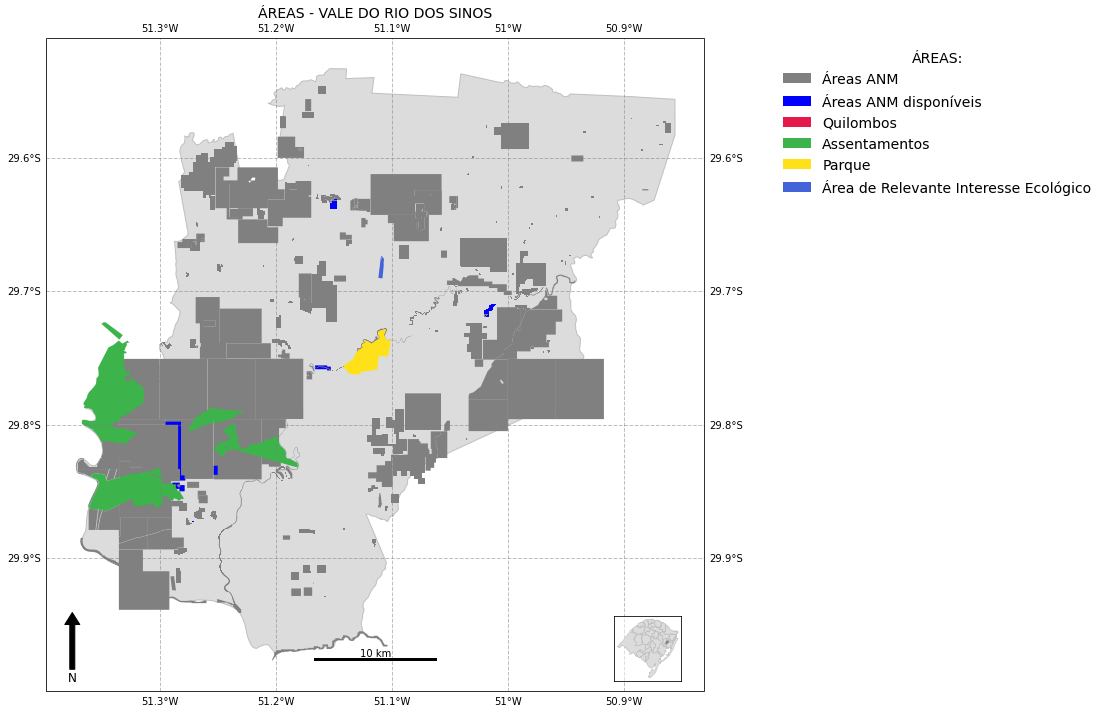

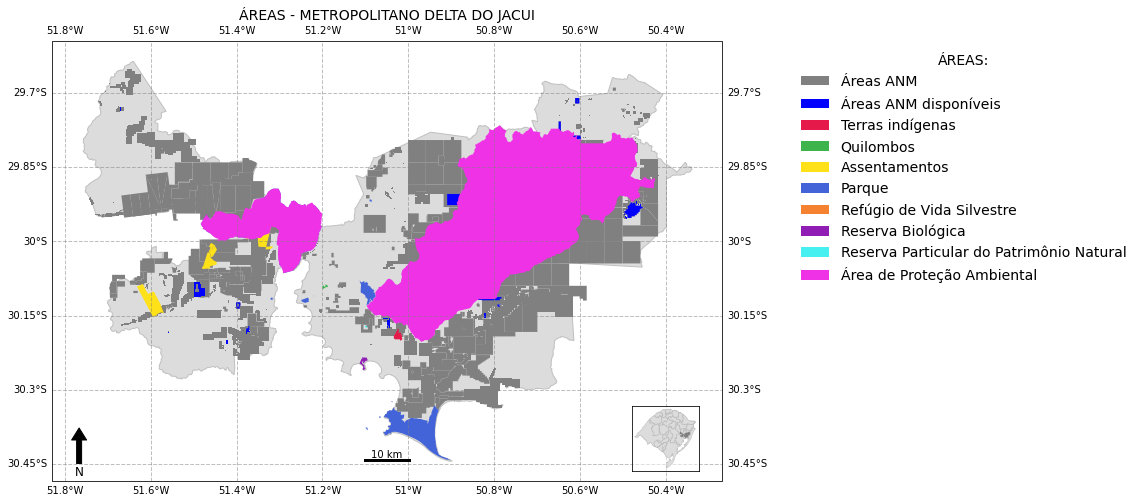

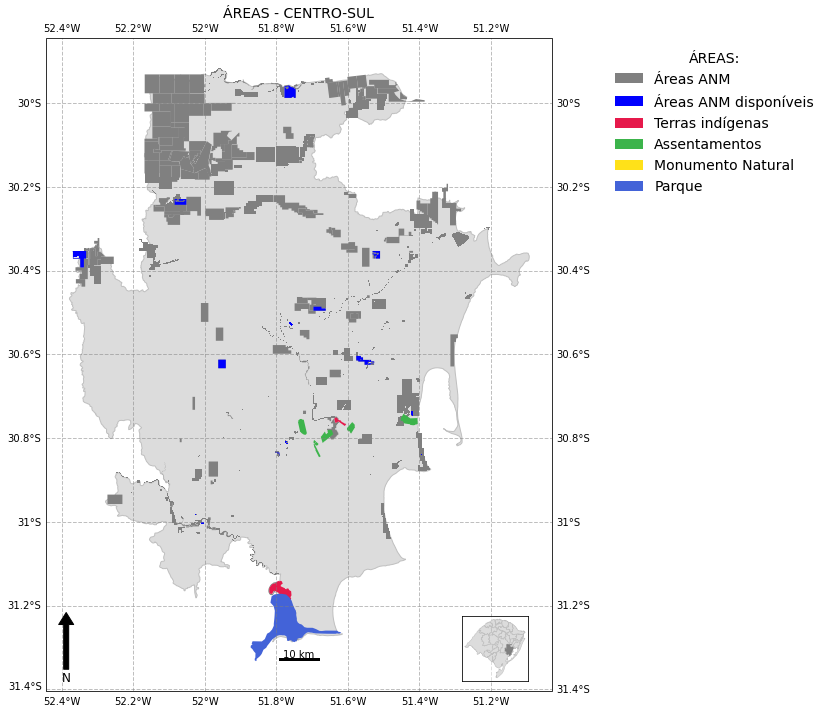

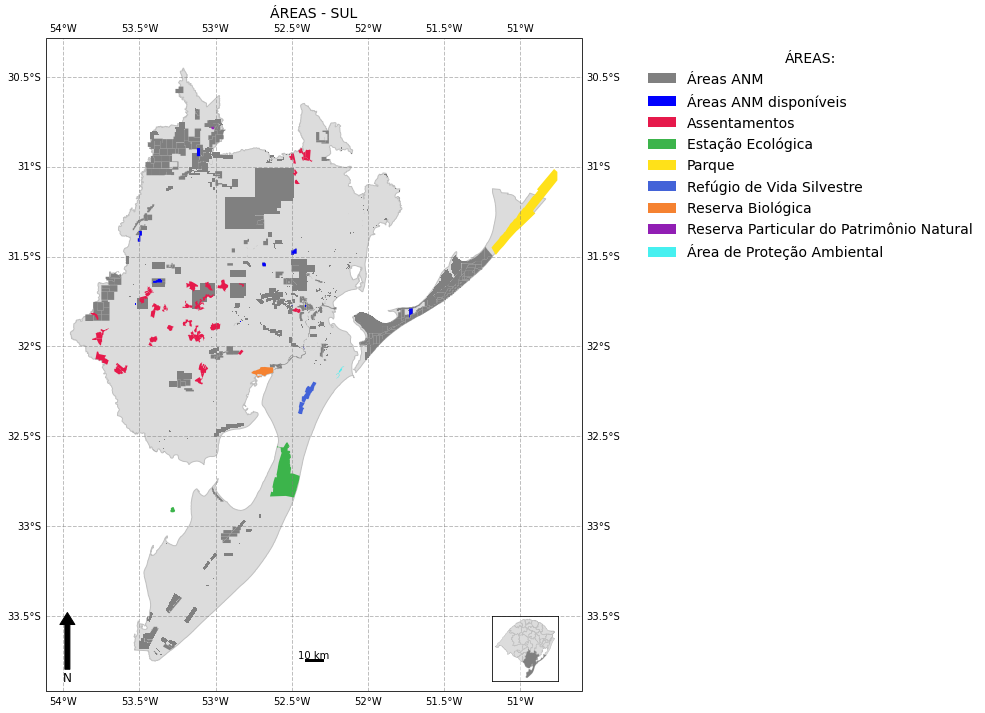

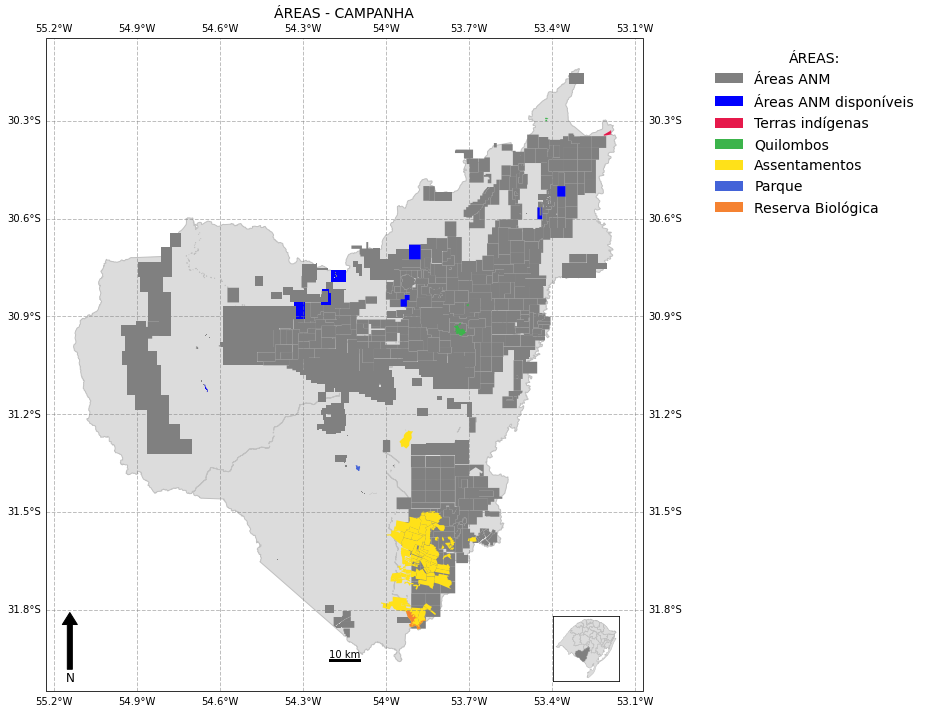

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

for idx, row in corede.iterrows():
    hand = []
    
    nome_cored = row['COREDE']
    
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    corede.iloc[[idx]].plot(ax=ax, color='gainsboro', edgecolor='silver')
    
    #sigmine
    sig_i = False
    for sidx, srow in sigmine.iterrows():
        i = srow['geometry'].centroid
        if row['geometry'].contains(i):
            sig_i = True
            sigmine.iloc[[sidx]].plot(ax=ax, color='gray')
     
    if sig_i == True:
        h = mpatches.Patch(facecolor='gray',label='Áreas ANM')
        hand.append(h)
        
    #sigmine dispoibilidade
    sigmined = sigmine[sigmine['FASE']=='DISPONIBILIDADE'].reset_index()
    sig_d = False
    for sidd, srowd in sigmined.iterrows():
        i = srowd['geometry'].centroid
        if row['geometry'].contains(i):
            sig_d = True
            sigmined.iloc[[sidd]].plot(ax=ax, color='blue')
     
    if sig_d == True:
        h = mpatches.Patch(facecolor='blue',label='Áreas ANM disponíveis')
        hand.append(h)
            
    cc = 0
    #terras indigenas
    ti_i = False
    for sidx, srow in ti.iterrows():
        i = srow['geometry'].centroid
        if row['geometry'].contains(i):
            ti_i = True
            ti.iloc[[sidx]].plot(ax=ax, color=colors[cc])
    
    if ti_i == True:
        h = mpatches.Patch(facecolor=colors[cc],label='Terras indígenas')
        hand.append(h)
        cc = cc + 1
        
    #quilombos
    qui_i = False
    for sidx, srow in qui.iterrows():
        i = srow['geometry'].centroid
        if row['geometry'].contains(i):
            qui_i = True
            qui.iloc[[sidx]].plot(ax=ax, color=colors[cc])
    
    if qui_i == True:
        h = mpatches.Patch(facecolor=colors[cc],label='Quilombos')
        hand.append(h)
        cc = cc + 1
        
    #assentamentos
    ass_i = False
    for sidx, srow in ass.iterrows():
        i = srow['geometry'].centroid
        if row['geometry'].contains(i):
            ass_i = True
            ass.iloc[[sidx]].plot(ax=ax, color=colors[cc])
    
    if ass_i == True:
        h = mpatches.Patch(facecolor=colors[cc], label='Assentamentos')
        hand.append(h)
        cc = cc + 1
        
    #grupos
    for c in ucs_cat:
        
        f = ucs['CATEGORI3'] == c
        f1 = uc_mun['tipo'] == c
        
        uc_mun_plot = uc_mun[f1]
        ucs_plot = ucs[f]
        
        ucs_i = False
        for asidx, asrow in ucs_plot.iterrows():
            i = asrow['geometry'].centroid
            if row['geometry'].contains(i):
                ucs_i = True
                ucs_plot.loc[[asidx]].plot(ax=ax, color=colors[cc])
         
        ucs_mun_i = False
        for bsidx, bsrow in uc_mun_plot.iterrows():
            i = bsrow['geometry'].centroid
            if row['geometry'].contains(i):
                ucs_mun_i = True
                uc_mun_plot.loc[[bsidx]].plot(ax=ax, color=colors[cc])
    
        if ucs_mun_i == True or ucs_i == True:
            h = mpatches.Patch(facecolor=colors[cc],label=c)
            hand.append(h)
            cc = cc + 1
        
    lgd1 = plt.legend(handles = hand, bbox_to_anchor=(1.1, 1), edgecolor = 'white', fontsize='14', title='ÁREAS:', title_fontsize='14', loc='upper left')

    scale_bar(ax, length=10, location=(0.5, 0.05), linewidth=3)
    
    x, y, arrow_length = 0.04, 0.12, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
    arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=12, xycoords=ax.transAxes)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    ax_ins = inset_axes(ax, width=1.3, height=0.9, borderpad=1, loc=4)
    ax_ins.set_xticks([])
    ax_ins.set_yticks([])
    ax_ins.patch.set_alpha(0.5)
    ax_ins.set_aspect('equal')
    
    corede.plot(ax=ax_ins, color='gainsboro', edgecolor='silver', linewidth=0.5)
    corede.iloc[[idx]].plot(ax=ax_ins, color='grey')
        
    ax.set_title('Áreas - {}'.format(nome_cored).upper(), loc='center', fontsize='14')
    plt.savefig('imagens/corede/'+nome_cored+".png", bbox_inches='tight', facecolor='white', dpi = 300)
    plt.show()